✅ Loaded dataset with 36,238 rows and 17 columns.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ Model training complete.

📊 MODEL PERFORMANCE
Train AUC: 0.933 | Valid AUC: 0.921
Train Acc: 0.865 | Valid Acc: 0.861
Valid Precision: 0.836, Recall: 0.716, F1: 0.771

              precision    recall  f1-score   support

Not Canceled       0.87      0.93      0.90      4872
    Canceled       0.84      0.72      0.77      2376

    accuracy                           0.86      7248
   macro avg       0.85      0.82      0.84      7248
weighted avg       0.86      0.86      0.86      7248



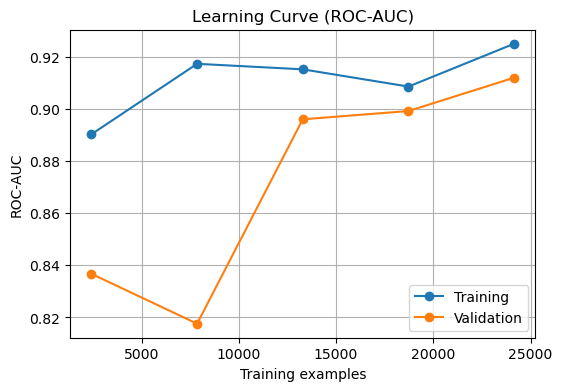

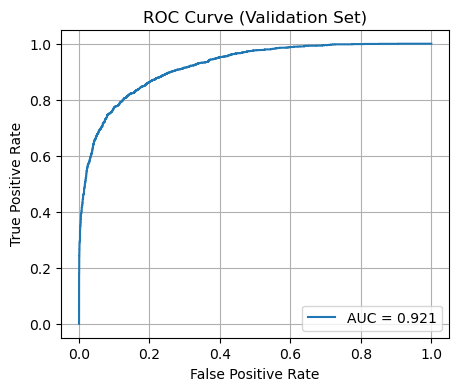

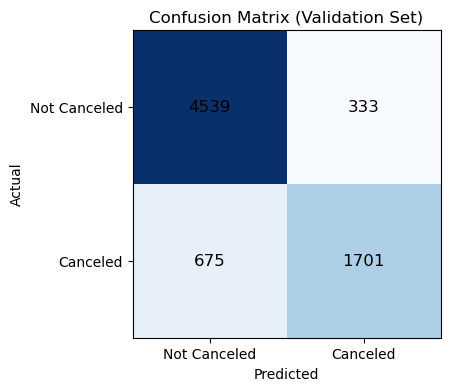

✅ All artifacts saved to: /Users/thegootch/Desktop/Data Science/merrimack/ml_ai/week5/artifacts


In [14]:
# === HOTEL BOOKING CANCELLATION PREDICTION (DENSE NN) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve
)

# ---------------------------------------------------------------------
# 1. LOAD & CLEAN DATA
# ---------------------------------------------------------------------
csv_path = "project_data.csv"  # <-- update path if needed
df = pd.read_csv(csv_path)
print(f"✅ Loaded dataset with {len(df):,} rows and {len(df.columns)} columns.")

# Drop unique ID
if "Booking_ID" in df.columns:
    df = df.drop(columns=["Booking_ID"])

# Normalize target variable
df["booking_status"] = df["booking_status"].astype(str).str.strip().str.lower()
label_map = {
    "canceled": 1, "cancelled": 1,
    "not_canceled": 0, "not cancelled": 0, "not-canceled": 0, "not canceled": 0
}
df["booking_status"] = df["booking_status"].map(label_map)
df = df.dropna(subset=["booking_status"])
df["booking_status"] = df["booking_status"].astype(int)

# Calendar features
if "arrival_date" in df.columns:
    df["arrival_date"] = pd.to_datetime(df["arrival_date"], errors="coerce")
    df["arrival_month"] = df["arrival_date"].dt.month
    def month_to_season(m):
        if pd.isna(m): return np.nan
        m = int(m)
        if m in [12,1,2]: return "winter"
        if m in [3,4,5]: return "spring"
        if m in [6,7,8]: return "summer"
        return "fall"
    df["arrival_season"] = df["arrival_month"].map(month_to_season)

# ---------------------------------------------------------------------
# 2. DEFINE COLUMNS & PREPROCESSOR
# ---------------------------------------------------------------------
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "booking_status"]
for c in ["type_of_meal_plan", "room_type_reserved", "market_segment_type", "arrival_season"]:
    if c in df.columns and c not in cat_cols:
        if not pd.api.types.is_numeric_dtype(df[c]):
            cat_cols.append(c)
num_cols = [c for c in df.columns if c not in cat_cols + ["booking_status", "arrival_date"]
            and pd.api.types.is_numeric_dtype(df[c])]

X = df.drop(columns=["booking_status"])
y = df["booking_status"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Handle OneHotEncoder compatibility 
onehot_args = {"handle_unknown": "ignore"}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    onehot_args["sparse_output"] = False  # sklearn >=1.2
else:
    onehot_args["sparse"] = False         # sklearn <1.2

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**onehot_args))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

# ---------------------------------------------------------------------
# 3. TRAIN / VALIDATION SPLIT
# ---------------------------------------------------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=21
)

# ---------------------------------------------------------------------
# 4. DEFINE & TRAIN MODEL
# ---------------------------------------------------------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,                 # L2 regularization
    batch_size=512,
    learning_rate="adaptive",
    learning_rate_init=1e-3,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=5,
    random_state=21,
    verbose=False
)

clf = Pipeline([("preprocessor", preprocessor), ("mlp", mlp)])
clf.fit(X_train, y_train)
print("✅ Model training complete.\n")

# ---------------------------------------------------------------------
# 5. EVALUATE MODEL
# ---------------------------------------------------------------------
y_train_proba = clf.predict_proba(X_train)[:, 1]
y_valid_proba = clf.predict_proba(X_valid)[:, 1]
y_train_pred = (y_train_proba >= 0.5).astype(int)
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

train_auc = roc_auc_score(y_train, y_train_proba)
valid_auc = roc_auc_score(y_valid, y_valid_proba)
train_acc = accuracy_score(y_train, y_train_pred)
valid_acc = accuracy_score(y_valid, y_valid_pred)
p_va, r_va, f1_va, _ = precision_recall_fscore_support(y_valid, y_valid_pred, average="binary", zero_division=0)

print("📊 MODEL PERFORMANCE")
print(f"Train AUC: {train_auc:.3f} | Valid AUC: {valid_auc:.3f}")
print(f"Train Acc: {train_acc:.3f} | Valid Acc: {valid_acc:.3f}")
print(f"Valid Precision: {p_va:.3f}, Recall: {r_va:.3f}, F1: {f1_va:.3f}\n")
print(classification_report(y_valid, y_valid_pred, target_names=["Not Canceled", "Canceled"]))

# ---------------------------------------------------------------------
# 6. LEARNING CURVE
# ---------------------------------------------------------------------
train_sizes, train_scores, valid_scores = learning_curve(
    clf, X, y, cv=3, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.title("Learning Curve (ROC-AUC)")
plt.plot(train_sizes, train_mean, marker='o', label="Training")
plt.plot(train_sizes, valid_mean, marker='o', label="Validation")
plt.xlabel("Training examples")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.legend()
plt.show()

# ---------------------------------------------------------------------
# 7. ROC CURVE
# ---------------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
plt.figure(figsize=(5,4))
plt.title("ROC Curve (Validation Set)")
plt.plot(fpr, tpr, label=f"AUC = {valid_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------
# 8. CONFUSION MATRIX
# ---------------------------------------------------------------------
cm = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(4,4))
plt.title("Confusion Matrix (Validation Set)")
plt.imshow(cm, cmap="Blues")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)
plt.xticks([0,1], ["Not Canceled", "Canceled"])
plt.yticks([0,1], ["Not Canceled", "Canceled"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------------------------------------
# 9. SAVE ARTIFACTS
# ---------------------------------------------------------------------
out_dir = Path("artifacts")
(out_dir / "figures").mkdir(parents=True, exist_ok=True)

metrics = pd.DataFrame([{
    "train_auc": train_auc, "valid_auc": valid_auc,
    "train_acc": train_acc, "valid_acc": valid_acc,
    "valid_precision": p_va, "valid_recall": r_va, "valid_f1": f1_va
}])
metrics.to_csv(out_dir / "metrics_summary.csv", index=False)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label="Training")
plt.plot(train_sizes, valid_mean, marker='o', label="Validation")
plt.xlabel("Training examples"); plt.ylabel("ROC-AUC")
plt.title("Learning Curve (ROC-AUC)")
plt.grid(True); plt.legend()
plt.savefig(out_dir / "figures" / "learning_curve_auc.png", bbox_inches="tight")
plt.close()

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {valid_auc:.3f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend(); plt.grid(True)
plt.savefig(out_dir / "figures" / "roc_curve_validation.png", bbox_inches="tight")
plt.close()

plt.figure()
plt.imshow(cm, cmap="Blues")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)
plt.xticks([0,1], ["Not Canceled", "Canceled"])
plt.yticks([0,1], ["Not Canceled", "Canceled"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.savefig(out_dir / "figures" / "confusion_matrix.png", bbox_inches="tight")
plt.close()

print(f"✅ All artifacts saved to: {out_dir.resolve()}")
